In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Plotting models fitted with fastNeutrino

In [71]:
def import_fastNeutrino_fit(fn):
    times = []
    functions = []
    with open(fn) as f:
        header = f.readline()
        n_anc = int(f.readline())
        for line in f:
            if line.startswith('c'):
                n, t = list(map(float, line.split()[-2:]))
                print(n,t)
            elif line.startswith('e'):
                pass
            else:
                break
        #return n_anc, params

In [72]:
chroms = ['Chr' + x for x in ['2L','2R','3L','3R']]

In [73]:
models = ['2EpochC', '2EpochE']

In [74]:
for c in chroms:
    model = import_fastNeutrino_fit('../fastNeutrino/fitted_params/{}.2EpochC.txt'.format(c))
    print(model)

758086.516 33169.7
None
772058.4796 26249.9
None
635450.7226 23552.5
None
825823.0018 46596.9
None


# numpy.piecewise

In [22]:
x = np.arange(1,100)

In [18]:
y = np.piecewise(x, [x<50, x>=50], [5,lambda x: x])

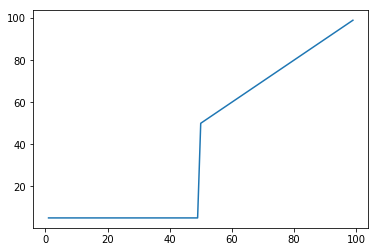

In [19]:
plt.plot(x,y)

In [11]:
z = np.piecewise(x, [10<x<50, x<80], [5,10])
plt.plot(x,z)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [31]:
f = lambda x: np.piecewise(x, [x<50, x>=50], [1, lambda v: np.exp(v/100.0)])

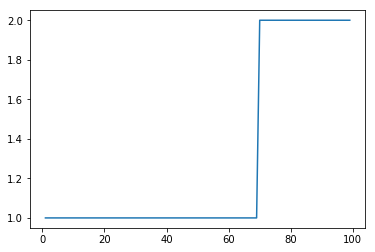

In [32]:
plt.plot(x,f(x))

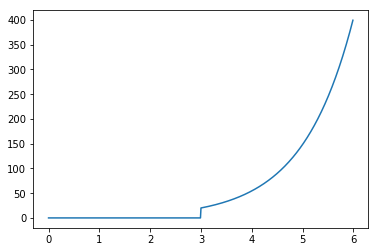

In [40]:
a = np.arange(0,6,0.01)
b = np.piecewise(a, [a<3,a>=3], [0,lambda c: np.exp(c)])
plt.plot(a,b)

In [48]:
f = lambda x: np.piecewise(x, [x>=0,x>=3,x>=5], [1,lambda c: np.exp(c), 100])

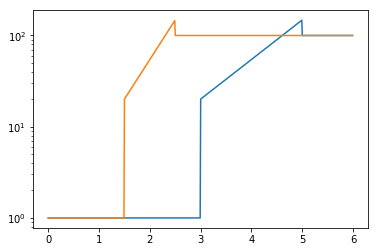

In [49]:
plt.semilogy(a,f(a))
plt.semilogy(a,f(2*a))